In [33]:
# import libraries
import warnings #shut warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import random
import itertools #usefull for gridsearch 
from datetime import datetime

import numpy as np # linear algebra
import pandas as pd # data processing, 
#### text processing bib
import unicodedata
from string import punctuation 
# # Spacy
# !python -m spacy download en
# !python -m spacy download en_core_web_lg
import spacy
# Nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('words')
from nltk.corpus import words
### networking biblio
import networkx as nx
from tqdm import tqdm
## bib for analyse
import seaborn as sns
#### Modeling bib
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split
### Regressor models
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

## greedy rsearch

### optimization bib

# root data
import os
for dirname, _, filenames in os.walk('/kaggle/input') :
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
/kaggle/input/2021-reddit-score-prediction/comments_students.csv


# Import baseline data

In [ ]:
df= pd.read_csv('/kaggle/input/2021-reddit-score-prediction/comments_students.csv')

# Columns description

In [ ]:
# Useless columns
df['subreddit_id'].value_counts() #useless
df['subreddit'].value_counts() # useless
#-------------------------------------------------------------------------
# Useful columns
df['created_utc']
df['id'].head() #useless car contenu dans name
df['name'] #id du commentaire (unique) 
df['link_id'] # link id (id du post ) https://www.reddit.com/r/help/comments/3p43su/what_is_a_reddit_id/
df['author'].value_counts() #nom de l'auteur
df['body'] #contenu du commentaire
df['parent_id'].head() #id de l'objet dont le commentaire est une réponse

## Creation of columns that could be interesting 

In [ ]:
#temporary data regarding comments (hours,days)
df['date'] = pd.to_datetime(df['created_utc'],unit='s')
df['heure'] = [i.hour for i in df['date']]
df['jour'] = [i.weekday() for i in df['date']]

In [ ]:
#if a comment's body have been deleted or not
df['isDeleted'] = [int(i=='[deleted]') for i in df['body']]

In [ ]:
#If a comment replies to another comment or directly to the post
df['answerPost'] = [int(str(i[:2])=='t3') for i in list(df['parent_id'])]

In [ ]:
#Proportion of capital letters in comment's body
def ratioMajuscule(message) :
    miniscules = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    majuscules = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    nbreMiniscules = sum([int(i in miniscules ) for i in message ])
    nbreMajuscules = sum([int(i in majuscules ) for i in message ])
    return nbreMiniscules,nbreMajuscules
listeRatioMajuscule = []
for i in tqdm(df['body']) :
    ratM,ratm = ratioMajuscule(str(i))
    try :
        listeRatioMajuscule.append(ratM/(ratM+ratm))
    except :
        listeRatioMajuscule.append(0)
df['ratioMaj'] = listeRatioMajuscule  

In [ ]:
#the number of negative ratings an author has received in the past
groupsAuteursNotes = df[['author','ups']].groupby('author').agg(list)
def ratioPos(array_) :
    return len([i for i in array_ if i<0 ])
groupsAuteursNotes['ratioNeg'] = groupsAuteursNotes['ups'].apply(ratioPos)
dicoAuteurRatio = pd.Series(groupsAuteursNotes.ratioNeg,index=groupsAuteursNotes.index).to_dict()
listeRatioNotes = []
for commentaire in range(len(df)) :
    listeRatioNotes.append(dicoAuteurRatio[df['author'].iloc[commentaire]])
df['ratioNoteNeg'] = listeRatioNotes  

In [ ]:
#Integer value for each authors
df['author_num'] = pd.factorize(df.author)[0]

# I- Data Preprocessing

## I-1 Analyse by text features

In [ ]:
## 1 nettoyage preprocessing :

def nettoyage(sen):
    stop = stopwords.words('english')
    punctuations=punctuation+"’”“‘…„—᾿‐–‑′•›‹⁄―‚→（）『』》《。↓↵'͞ʻʿ'"+'″￼'
#     sen = sen[0:10000]
    #  lower
    sentence = str(sen).lower()
    #supprission space(de debut et fin)
    sentence = str(sentence).strip()
    #supprission space
    sentence = " ".join(sentence.split())
    # supprission punctuation
    for p in punctuations:
        sentence = sentence.replace(p," ")
    #supprision des accents
    sentence = ''.join((c for c in unicodedata.normalize('NFD', sentence) if unicodedata.category(c) != 'Mn'))
    #supprision des chiffres
    sentence = ''.join([i for i in sentence if not i.isdigit()])
    #supprision des mots <2 ou >50
    sentence = ' '.join([w for w in sentence.split() if len(w)>1])
    sentence = ' '.join([w for w in sentence.split() if len(w)<50])
    return sentence

### application des fonctions:
df['clen_body']=df['body'].apply(nettoyage)

In [ ]:
#Get words'number on each comment
def len_text(text):
    k=str(text).split()
    return len(k)
df['len_body']=df['clen_body'].apply(len_text)

In [ ]:
# ## lemmatization de body
# ## fonction de limmatization

def lemmatization(text):
    nlp = spacy.load('en_core_web_lg')
    doc = nlp(text)
    return ' '.join([(d.lemma_) for d in doc])
# df.head()
df['lem_body']=df['clen_body'].apply(lemmatization)
## easy by for loop

In [ ]:
# ## 2 TF-IDF on lem_Body column
# # dftf=df.clen_body.fillna(' ') ## remlire les nans body par espace
vectorizer = TfidfVectorizer(max_df = 0.9,min_df = 0.01)
# Create TF-IDF matrix 
vectorizer.fit(dftf)
#######
features=vectorizer.transform(dftf)
### 3 similarity of by tf_idf
cos_sim=linear_kernel(features[0:1], features).flatten()
df['cos_sim']=list(cos_sim)

In [ ]:
### Analyse des sentiments subjectivity  & polarity 
subjec=[]
polar=[]
for i in tqdm(range(df.shape[0])) :
    subjec.append(TextBlob(str(df['clen_body'].iloc[i])).subjectivity)
    polar.append(TextBlob(str(df['clen_body'].iloc[i])).polarity)
df['subjectivity'] = subjec
df['polarity'] = polar

## I-2 Analyse By Networking

## Graph generation

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(list(df['name'])) #Création des noeuds commentaires
G.add_nodes_from(list(df['link_id'])) #Création des noeuds posts
for i in tqdm(range(df.shape[0])) :
    G.add_edge(df['parent_id'].iloc[i],df['name'].iloc[i]) #Création des liens entre les noeuds
nodesPeres = list(df['parent_id'])
nodesFils = list(df['name'])

### Calculate the number of child  (degree) for a comment and number of descendant (tree successors)

In [ ]:
nombreEnfants = [len(list(G.successors(i))) for i in (df['name'])]
nombreDescendants = [len(list(nx.nodes(nx.dfs_tree(G, i)))) for i in ( df['name'])]
df['nombreEnfants'] = nombreEnfants
df['nombreDescendants'] = nombreDescendants
df['ratioEnfantsDescendants'] = df['nombreEnfants'] / df['nombreDescendants']

## Calcul of  centrality Kats

In [ ]:
dicoCentralityKatz = nx.katz_centrality(G)
listcentralityKats = []
for i in tqdm(range(df.shape[0])) :
    listcentralityKats.append(dicoCentralityKatz[df['name'].iloc[i]])
df['centralityKats'] = listcentralityKats

## Calcul of centrality Eigen

In [ ]:
dicoCentralityEigen = nx.eigenvector_centrality(G)
listcentralityEigen = []
for i in tqdm(range(df.shape[0])) :
    listcentralityEigen.append(dicoCentralityEigen[df['name'].iloc[i]])
df['centralityEigen'] = listcentralityEigen

## Calcul of average neighbor degree

In [ ]:
dicoAverageNei = nx.average_neighbor_degree(G)
listAverageNei = []
for i in tqdm(range(df.shape[0])) :
    listAverageNei.append(dicoAverageNei[df['name'].iloc[i]])
df['averageNei'] = listAverageNei

## Closeness centrality for each node

In [ ]:
dicoClosenessCentrality = nx.closeness_centrality(G)
listClosenessCentrality = []
for i in tqdm(range(df.shape[0])) :
    listClosenessCentrality.append(dicoClosenessCentrality[df['name'].iloc[i]])
df['closenessCentrality'] = listClosenessCentrality

# Load centrality for each nodes

In [ ]:

listLoadCentrality = []
for i in tqdm(range(df.shape[0])) :
    listLoadCentrality.append(dicoLoadCentrality[df['name'].iloc[i]])
df['loadCentrality'] = listLoadCentrality

## Degree of the  post containing the comment

In [ ]:
listeEnfantPost = [len(list(G.successors(i))) for i in tqdm(df['link_id'] )]
df['enfantPost'] = listeEnfantPost

## Nombre de commentaires ayant le meme successor (commentaire auxquelles ils répondent)

In [ ]:
nbreFreres = []
for i in tqdm(range(df.shape[0])) :
    parent = df['parent_id'].iloc[i]
    nbreFreres.append(len(list(G.successors(parent))))
df['nombreFrere'] = nbreFreres

## On calcul le nombre et la moyenne d'enfant des commentaires situés autour du commentaire père

In [ ]:
moyennecousins = []
nombrecousins = []
for i in tqdm(range(df.shape[0])) :
    parent = df['parent_id'].iloc[i]
    listeFreres = list(G.successors(parent))
    moyennecousins.append(np.array([len(list(G.successors(i))) for i in listeFreres]).mean())
    nombrecousins.append(sum([len(list(G.successors(i))) for i in listeFreres]))
df['nombreCousins'] = nombrecousins
df['moyennecousins'] = moyennecousins

# Création d'un graphe non dirigé pour le calcul de certaines centralités (trop longue n'a pas pu être exploité)

In [ ]:
UG =  nx.Graph()
UG.add_nodes_from(list(df['name']))
UG.add_nodes_from(list(df['link_id']))
for i in tqdm(range(df.shape[0])) :
    UG.add_edge(df['parent_id'].iloc[i],df['name'].iloc[i])

## I-3 Finale Data

## I-4 Test correlation for some features

In [ ]:
sns.heatmap(df[['ups','nombreEnfants','nombreDescendants','nombreFrere','nombreCousins']].corr().abs())

# II- Modeling

## II-1 Split data

In [ ]:
#df_ est le train contenant les commentaires dont on connait la note
df_ = df[df['ups'].isna()==False].dropna()
features = list(df_.columns)#On prend toutes les colonnes on choisira lesquelles garder pour l'apprentissage du modèle
features.remove('ups')
X_train, X_test, y_train, y_test = train_test_split(df_[features], df_['ups'],random_state=1234)
X_train = pd.concat([X_train,y_train],axis=1)
X_test = pd.concat([X_test,y_test],axis=1)
#we choose to separate the data in two, the comments whose child number <=1 and the others
X_trainGrandNombreEnfant = X_train[X_train['nombreEnfants']>1]
X_testNbreGrand = X_test[(X_test['nombreEnfants'] >1) ]

X_testNbreEnfantPetit =X_test[(X_test['nombreEnfants'] ==1) | (df_['nombreEnfants'] ==0)]

## II-2 Training Models

In [31]:
###########  GradientBoostingRegressor with random features and parameters
model = GradientBoostingRegressor(n_estimators=100, min_samples_split=2, loss='lad', max_depth=7,criterion ='mse',learning_rate=0.1, subsample=0.5)
model.fit(X_train[['nombreEnfants','nombreDescendants']], X_train['ups']) 
np.abs(y_test-model.predict(X_test[['nombreEnfants','nombreDescendants']])).mean()

8.62315019621603

[0.59914459 0.40085541]


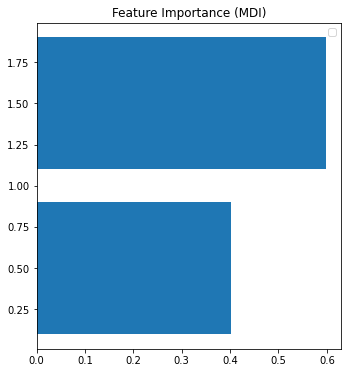

In [34]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.title('Feature Importance (MDI)')
print(feature_importance)
plt.legend()
plt.show()

# III - Models Optimization

## III-1 Prepare Rsearch Greedy Function.

# Try all combinations of features and parameters

In [37]:
#score return the mean absolute error beetween prediction and reality
def score(reel,prediction) :
    return np.abs(reel-prediction).mean()

def gridSearch(modele,parameters,xtrain,ytrain) :
    modele = modele(**parameters)
    return modele.fit(xtrain,ytrain)


def gridSearchPredict(modele,xtest,ytest) :
    return score(ytest,modele.predict(xtest))

def power_set(input):
    # returns a list of all subsets of the list a
    if (len(input) == 0):
        return [[]]
    else:
        main_subset = [ ]
        for small_subset in power_set(input[1:]):
            main_subset += [small_subset]
            main_subset += [[input[0]] + small_subset]
        return [i for i in main_subset if len(i)>0]
def allParameters(dictionnaire) :
    for element in itertools.product(*dictionnaire.values()):
        newdict = {}
        for key in range(len(dictionnaire.keys())) :
            newdict[list(dictionnaire.keys())[key]] = element[key]
        yield newdict

In [42]:
#our approach was to create two models, one to predict data with a low number of children 
#and one for comments with many children , 


input_features = ['nombreDescendants','isDeleted','nombreEnfants']
def testCombinations(modeleR,parameters):
    minNotePetite = 5
    minNoteGrande = 10000
    miteNoteAll = 15
    allFeaturesShuffled = random.sample(power_set(input_features),len(power_set(input_features)))
    allParameterslist = list(allParameters(parameters))
    allParameterslistShuffle = random.sample(allParameterslist, len(allParameterslist))
    for ft in tqdm(allFeaturesShuffled) :
        features_in = ft
        for param in (allParameterslistShuffle) :
            modeleEntraine = gridSearch(modeleR,param,np.array(X_sample[features_in]),X_sample['ups'])
            noteBeaucoup = gridSearchPredict(modeleEntraine,np.array(X_testNbreGrand[features_in]), #On calcul la note prédite sur les commentaires ayant + de une réponse
                                             np.array(X_testNbreGrand['ups']))
            notePetit = gridSearchPredict(modeleEntraine,np.array(X_testNbreEnfantPetit[features_in]), #On calcul la note prédite sur les commentaires ayant 0 ou une réponse
                                          np.array(X_testNbreEnfantPetit['ups']))
            noteAll = gridSearchPredict(modeleEntraine,  #prédiction de la note sur tout le dataframe
                                        np.array(X_test[features_in]),np.array(X_test['ups']))
            if minNotePetite>notePetit :
                minNotePetite = notePetit 
                print('Note Petit : ')
                print(notePetit)
                print(param)
                print(features_in)
                print("---------------")
            if minNoteGrande>noteBeaucoup :
                minNoteGrande = noteBeaucoup #On essaie de récupérer le modele qui minimise l'erreur sur les données ayant un grand degree (nombre enfant>1)
                print("note Grand : ")
                print(noteBeaucoup)
                print(param)
                print(features_in)
                print("---------------")
                modeleretour = modeleEntraine
            if miteNoteAll>noteAll :
                miteNoteAll = noteAll
                print("note All : ")
                print(noteAll)
                print(param)
                print(features_in)
                print("---------------")
    return modeleretour
                


## III-2 Get the optimales arguementes

# List of each parameters combination we want try

In [ ]:
randomForestParameters = {'n_estimators':[10],'max_depth':[4,5,6],'criterion':['mae'],'min_samples_split':[2,3,4]}
neuralNparameters = {'activation':['identity','logistic','tanh','relu'],
                     'solver':['lbfgs','sgd','adam'],
                    'learning_rate':['constant','invscaling','adaptive']}
gradientParameters = {'n_estimators':[10,100],'min_samples_split' : [2,3],'loss':['lad'],'max_depth':[3,5,7,9],'learning_rate':[0.1,0.01],'subsample':[0.8,1]}
lightgbmParameters = {'boosting_type':['gbdt','dart','goss']}

# VI- Prediction

In [44]:
X_sample = X_train.sample(100000)
modelePetit = testCombinations(GradientBoostingRegressor,{'loss': ['lad'], 'min_samples_split':[2], 'max_depth': [3,5,7], 'n_estimators': [100], 'learning_rate': [0.1]})    

 25%|██▌       | 1/4 [00:00<00:01,  2.32it/s]

Note Petit : 
1.9502930998824926
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreEnfants']
---------------
note Grand : 
101.16040149746323
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreEnfants']
---------------
note All : 
9.362183303265939
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreEnfants']
---------------


 50%|█████     | 2/4 [00:01<00:01,  1.51it/s]

Note Petit : 
1.9476091866529004
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'isDeleted', 'nombreEnfants']
---------------
note Grand : 
98.2607865156945
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'isDeleted', 'nombreEnfants']
---------------
note All : 
9.143072502155775
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'isDeleted', 'nombreEnfants']
---------------


100%|██████████| 4/4 [00:02<00:00,  1.59it/s]

note Grand : 
97.82016978865437
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'nombreEnfants']
---------------
note All : 
9.112496639734319
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'nombreEnfants']
---------------


In [45]:
#Calcul du modèle pour les commentaires ayant beaucoup d'enfants
X_sample = X_trainGrandNombreEnfant
modele = testCombinations(GradientBoostingRegressor,{'loss': ['lad'], 'min_samples_split':[2,5,7], 'max_depth': [3,5,8,9], 'n_estimators': [10,100], 'learning_rate': [0.1]})    

 25%|██▌       | 1/4 [00:00<00:02,  1.40it/s]

note Grand : 
100.19370595332491
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreEnfants']
---------------
note All : 
12.740069693818445
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreEnfants']
---------------


 50%|█████     | 2/4 [00:02<00:02,  1.29s/it]

note Grand : 
97.27767277951898
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'nombreEnfants']
---------------
note All : 
12.048481763189095
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'nombreEnfants']
---------------


100%|██████████| 4/4 [00:05<00:00,  1.30s/it]

note Grand : 
97.23278449838278
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'isDeleted', 'nombreEnfants']
---------------
note All : 
11.960464578861641
{'loss': 'lad', 'min_samples_split': 2, 'max_depth': 8, 'n_estimators': 10, 'learning_rate': 0.1}
['nombreDescendants', 'isDeleted', 'nombreEnfants']
---------------


# PREDICTIONS

In [48]:
df_petit = df_[df_['nombreEnfants']<=1]
df_grand = df_[df_['nombreEnfants']>1]
dfPredire = df[df['ups'].isna()==True]
dfPredirePetit = dfPredire[dfPredire['nombreEnfants']<=1]
dfPredireGrand = dfPredire[dfPredire['nombreEnfants']>1]

In [ ]:
X_sample = X_train
modelPetit = GradientBoostingRegressor(loss='lad',n_estimators=1000,max_depth=8,learning_rate=0.1,subsample=1,min_samples_split=2,criterion= 'mse')
modelPetit.fit(X_sample[['nombreEnfants', 'nombreDescendants', 'nombreFrere', 'ratioEnfantsDescendants', 'isDeleted', 'moyennecousins', 'centralityEigen', 'averageNei', 'centralityKats']],X_sample['ups'])
predictedPetit = modelPetit.predict(dfPredirePetit[['nombreEnfants', 'ratioEnfantsDescendants', 'heure', 'motNegatifs', 'nombreDescendants', 'enfantPost', 'nombreFrere', 'isDeleted', 'centralityEigen', 'centralityKats', 'averageNei', 'loadCentrality', 'answerPost', 'nombreCousins']])

In [ ]:
X_sample = X_trainGrandNombreEnfant
modeleGrand = GradientBoostingRegressor(loss='lad',n_estimators=1000,max_depth=11,learning_rate=0.01,min_samples_split=9,subsample=0.8,criterion= 'mse')
modeleGrand.fit(X_sample[['nombreEnfants', 'nombreDescendants', 'closenessCentrality', 'enfantPost', 'nombreFrere', 'isDeleted', 'centralityEigen', 'centralityKats', 'averageNei', 'loadCentrality', 'answerPost', 'nombreCousins']],X_sample['ups'])
predictedGrand = modeleGrand.predict(dfPredireGrand[['nombreEnfants', 'nombreDescendants', 'closenessCentrality', 'enfantPost', 'nombreFrere', 'isDeleted', 'centralityEigen', 'centralityKats', 'averageNei', 'loadCentrality', 'answerPost', 'nombreCousins']])

In [ ]:
prediction = list(predictedPetit) + list(predictedGrand)
ids = list(dfPredirePetit['id']) + list(dfPredireGrand['id'])
dfPrediction = pd.DataFrame(prediction)
dfPrediction['id'] = ids
dfPrediction.columns = ['predicted','id']
dfPrediction.to_csv('prediction12_04.csv',index=False)